# Imports

In [1]:
import sys
import io

import itertools
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import StratifiedShuffleSplit

# Helper functions

In [2]:
def stats(y_true, y_pred):
    
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    
    print ("Accuracy: {}".format(accuracy))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    See: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    plt.figure(figsize=(20,10))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

# Read Data

In [3]:
X_train = pd.read_csv("./data/train/X_train.txt", sep=r"\s*", header=None, engine='python')
y_train = pd.read_csv("./data/train/y_train.txt", sep=r"\s*", header=None, engine='python')

X_test = pd.read_csv("./data/test/X_test.txt", sep=r"\s*", header=None, engine='python')
y_test = pd.read_csv("./data/test/y_test.txt", sep=r"\s*", header=None, engine='python')

#Modify labels to be in [0, 12)
y_train = y_train - 1
y_test = y_test - 1

## Preform stratified split

In [4]:
sss = StratifiedShuffleSplit(test_size=.1, n_splits=1)
train_indices, validation_indices = sss.split(X_train, y_train).next()

X_validation = X_train.loc[validation_indices]
y_validation = y_train.loc[validation_indices]

X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]

In [5]:
print "Training size: {}, Validation Size: {}, Test size: {}".format(len(y_train), len(y_validation), len(y_test))

Training size: 6616, Validation Size: 736, Test size: 2947


# Read Activity Labels

In [7]:
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

activity_labels = u""

with open('./data/activity_labels.txt') as f:
    for line in f:
        activity_labels += line.strip() + "\n"

activity_labels = io.StringIO(activity_labels)
activity_labels = pd.read_csv(activity_labels, sep=" ", header=None, names=["id","name"])
activity_labels.loc[:,['id']] = activity_labels['id'] -1 

# Random Forest Classifier

In [8]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalidation = xgb.DMatrix(data=X_validation, label=y_validation)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [9]:
param = {'eta':0.3, 'silent':False, 'objective':'multi:softmax', 'num_class': 12}
num_round = 20

In [10]:
model = xgb.train(param, dtrain, num_round, verbose_eval=True, 
                  evals=[(dtrain, "train"), (dvalidation, "validation")])

[0]	train-merror:0.027207	validation-merror:0.061141
[1]	train-merror:0.017684	validation-merror:0.052989
[2]	train-merror:0.013906	validation-merror:0.047554
[3]	train-merror:0.011941	validation-merror:0.046196
[4]	train-merror:0.00786	validation-merror:0.035326
[5]	train-merror:0.005441	validation-merror:0.035326
[6]	train-merror:0.004081	validation-merror:0.03125
[7]	train-merror:0.002721	validation-merror:0.025815
[8]	train-merror:0.001965	validation-merror:0.023098
[9]	train-merror:0.00136	validation-merror:0.02038
[10]	train-merror:0.00136	validation-merror:0.021739
[11]	train-merror:0.000756	validation-merror:0.021739
[12]	train-merror:0.000453	validation-merror:0.017663
[13]	train-merror:0.000302	validation-merror:0.017663
[14]	train-merror:0.000151	validation-merror:0.017663
[15]	train-merror:0	validation-merror:0.017663
[16]	train-merror:0	validation-merror:0.017663
[17]	train-merror:0	validation-merror:0.017663
[18]	train-merror:0	validation-merror:0.017663
[19]	train-merror

In [11]:
y_pred = model.predict(dtest)

Confusion matrix, without normalization
[[484   3   9   0   0   0]
 [ 48 417   6   0   0   0]
 [  5  34 381   0   0   0]
 [  0   1   0 402  88   0]
 [  0   0   0  41 491   0]
 [  0   0   0   0   0 537]]


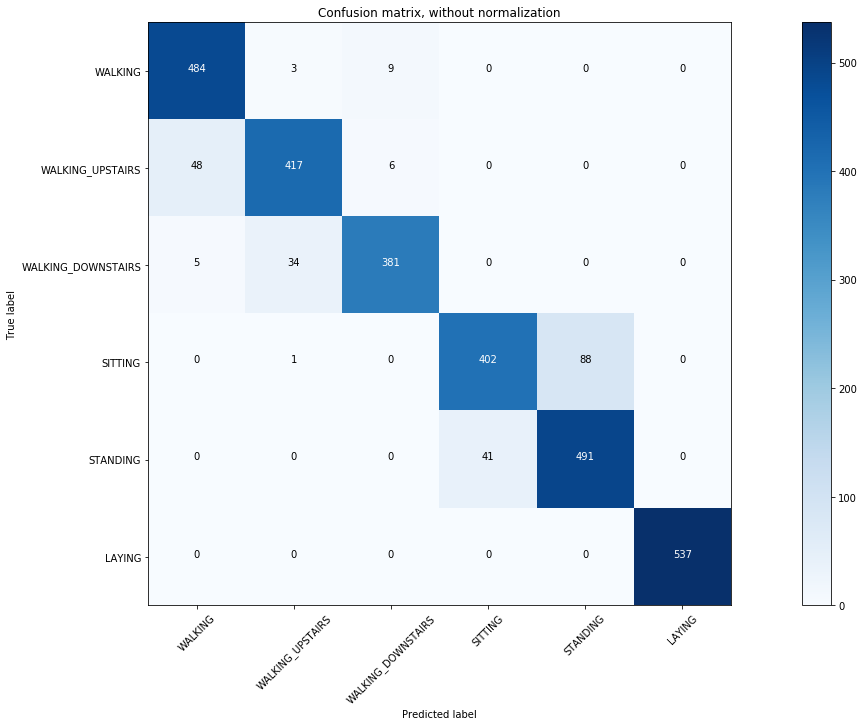

In [12]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=activity_labels.name.values, 
                      title='Confusion matrix, without normalization')

In [13]:
stats(y_true=y_test, y_pred=y_pred)

Accuracy: 0.920257889379
